In the notebook `KBDL_December2nd_optim-crossval`, it was noticed that adding a local short-timescale component to the predictive covariance
allowed the maximum a posteriori imputation to fit the true temperatures very closely. The question then is whether such a component could help the imputations more generally.
We will run the same Stan imputations twice: once with the normal predictive covariance, and then with an added local component.
The hope is that the imputations will fit the truth more closely.

In [1]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=120.0)
# plt.rc("figure", figsize=(6,4))
plt.rc("savefig", dpi=120.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
cbbPalette = ["#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]
;

In [2]:
using Printf
using DataFrames
using JLD
using Dates
using GaussianProcesses: set_params!
import JSON
using Dates
using PDMats
using LinearAlgebra
using Statistics
using StatsBase: midpoints, Weights
using Distributions
using GaussianProcesses
using CmdStan

GPmodel="matern"
ICAO="KBDL"
data_dir="../data"
save_dir="/Volumes/Samsung250GB/saved"
k_nearest=5

5

In [3]:
using Revise
import TempModel

In [7]:
module Batch
    using TempModel
    import PyPlot; plt=PyPlot
    using LaTeXStrings
    using DataFrames
    using Dates
    using Distributions
    using PDMats
    using LinearAlgebra
    using Printf
    ;
    src_dir = dirname(pathof(TempModel))
    include(joinpath(src_dir, "batch_diagnostics.jl"))
    include(joinpath(src_dir, "plot_diagnostics.jl"))
    include(joinpath(src_dir, "infermean.jl"))
#     include(joinpath(src_dir, "plot_map.jl"))
end

Main.Batch

In [8]:
# load kernel hyperparameters from JSON file
json_fname = @sprintf("hyperparams_%s_%s.json", GPmodel, ICAO)
json_filepath = joinpath(save_dir, "fitted_kernel", "crossval", GPmodel, json_fname)
open(json_filepath, "r") do io
    global output_dictionary = JSON.parse(io)
end
@assert output_dictionary["test_ICAO"] == ICAO

epsg = 3857 # Web Mercator (m)
isdList = TempModel.read_isdList(; data_dir=data_dir, epsg=epsg)
isd_wData = TempModel.stations_with_data(isdList; data_dir=data_dir)

test_station = isd_wData[isd_wData[:ICAO].==ICAO, :]
@assert nrow(test_station) == 1
USAF = test_station[1, :USAF]
WBAN = test_station[1, :WBAN]

isd_nearest_and_test = TempModel.find_nearest(isd_wData, USAF, WBAN, k_nearest)

hourly_cat=TempModel.read_Stations(isd_nearest_and_test; data_dir=data_dir)
itest=1 # first row of isd_nearest_and_test is the test station
timezoneGMT = -5 # Georgia
# timezoneGMT = -7 # Arizona
local_time(ts) = ts - Hour(timezoneGMT)
ilocaltime = circshift(1:24, -timezoneGMT)
;

In [9]:
hr_measure = Hour(17)
TnTx = TempModel.test_data(hourly_cat, itest, hr_measure)
hourly_train = hourly_cat[hourly_cat[:station].!=itest,:]
hourly_test  = hourly_cat[hourly_cat[:station].==itest,:]
hourly_test[:ts_day] = [TempModel.measurement_date(t, hr_measure) for t in hourly_test[:ts]]
# add column to test data for TnTx (useful for plotting)
hourly_test = join(hourly_test, TnTx, on=:ts_day)
;

# Running Stan

In [14]:
test_fw = Batch.FittingWindow(Date(2015,5,2),Date(2015,7,14))
nearby_pred = Batch.get_nearby(test_fw, GPmodel, USAF, WBAN, ICAO, save_dir; crossval=true)
date_start = Date(2015,5,28)
impute_window = Day(7)
stan_data, ts_window = TempModel.prep_data(nearby_pred, TnTx, date_start, hr_measure, impute_window;
    ksmoothmax=50.0, epsilon=0.1) # relaxed k, strict epsilon
imputation_model = TempModel.get_imputation_model(;seed=42) # Stan model
;

=====> /Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks



In [15]:
@time sim1 = stan(imputation_model, [stan_data], summary=true, diagnostics=false);


make: `/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation' is up to date.


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:

Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)


If this warning

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be e


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[2] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[6] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 61)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be ei


Calling /usr/local/Cellar/cmdstan/2.17.0/bin/stansummary to infer across chains.

Inference for Stan model: imputation_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (127, 130, 129, 134) seconds, 8.7 minutes total
Sampling took (112, 112, 112, 112) seconds, 7.4 minutes total

                     Mean     MCSE   StdDev     5%       50%       95%  N_Eff  N_Eff/s    R_hat
lp__             -1.5e+02  3.3e-01  1.2e+01   -167  -1.5e+02  -1.3e+02   1274  2.9e+00  1.0e+00
accept_stat__     9.3e-01  1.4e-03  9.0e-02   0.73   9.6e-01   1.0e+00   4000  9.0e+00  1.0e+00
stepsize__        2.1e-02  5.5e-04  7.8e-04  0.020   2.1e-02   2.2e-02    2.0  4.5e-03  2.3e+13
treedepth__       8.0e+00  8.4e-17  5.3e-15    8.0   8.0e+00   8.0e+00   4000  9.0e+00  1.0e+00
n_leapfrog__      2.5e+02  4.9e-14  3.1e-12    255   2.6e+02   2.6e+02   4000  9.0e+00  1.0e+00
divergent__       0.0e+00  0.0e+00  0.0e+00   0.00   0.0e+00   0.0e+0

257.427337 seconds (23.92 M allocations: 1.071 GiB, 0.23% gc time)


In [33]:
using AxisArrays
function Chains(samples::AbstractArray{Float64, 3}, names::AbstractVector{S}) where {S<:AbstractString}
    nsamples, ncol, nchains = size(samples)
    chains = AxisArray(samples, Axis{:sample}(1:nsamples), Axis{:param}(names), Axis{:chain}(1:nchains))
    return chains
end
function get_param_names(chains::AxisArray)
    # there should be a more elegant way to obtain the names of an axis
    PARAM = Axis{:param}
    jparam = axisdim(chains, PARAM)
    param_axis = AxisArrays.axes(chains)[jparam]
    param_names = axisvalues(param_axis)[1]
    return param_names
end
function get_temperatures_reparam(chains::AxisArray)
    param_names = get_param_names(chains)
    temp_varnames = [h for h in param_names if startswith(h, "temp_impt.")]
    temp_samples = view(chains, :, Axis{:param}(temp_varnames), :)
    return temp_samples
end
chainsarray = Chains(sim1[2], sim1[3])
@show size(chainsarray)
temp_impute = get_temperatures_reparam(chainsarray);

size(chainsarray) = (1000, 587, 4)


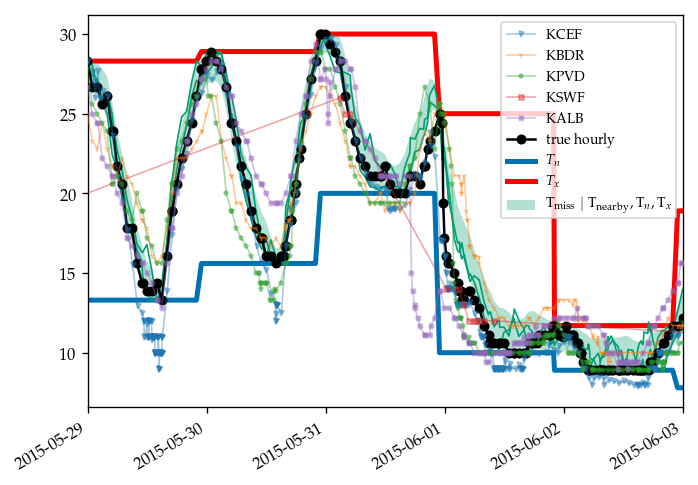

In [19]:
Batch.plot_imputations(ts_window, temp_impute, local_time; plot_mean=false, impt_indices=[250,500])
plt.gcf()[:autofmt_xdate]()
plt.xlim(Date(2015,5,29), Date(2015,6,3))
# plt.ylim(0,7)
_xlim = plt.xlim()
_ylim = plt.ylim()
Batch.plot_neighbours(hourly_train, 
                      isd_nearest_and_test,
                      local_time,
                      (DateTime(2015,5,2),DateTime(2015,7,14));
                      subtractmean=false,
#                       color="black",
                      linewidth=1,
                      markersize=3,
                      alpha=0.4,
                      zorder=10)
fw = Batch.FittingWindow(DateTime(2015,5,2),DateTime(2015,7,14))
Batch.plot_truth(hourly_test, fw, hr_measure, local_time)
Batch.plot_TnTx(hourly_cat, 1, hr_measure, local_time)
plt.xlim(_xlim)
plt.ylim(_ylim)
plt.legend(loc="auto", fontsize="small")
;

# Add local component

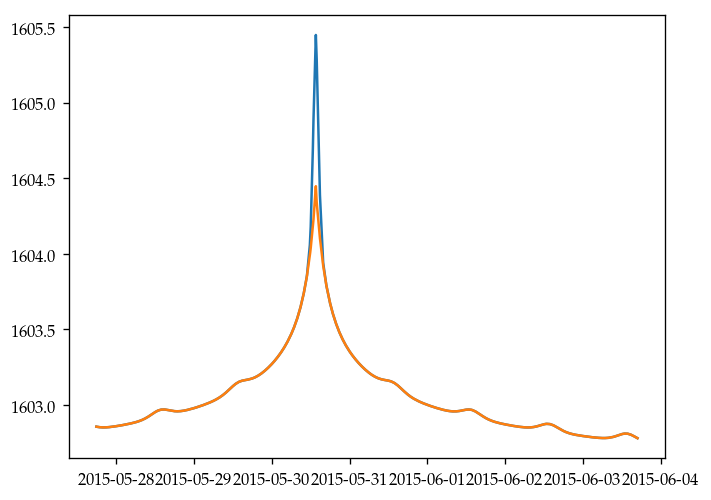

In [26]:
k_short = SEIso(log(0.8), log(1.0))

ts_window_hours = (ts_window .- ts_window[1]) ./ Millisecond(1) ./ (3600e3)
Σpred = stan_data["predicted_cov"]
Σmod = Σpred.+ cov(k_short, ts_window_hours')
plt.plot(ts_window, Σmod[100,:])
plt.plot(ts_window, Σpred[100,:])
Lmod = PDMats.PDMat(Σmod).chol.L
stan_data_mod = copy(stan_data)
stan_data_mod["predicted_cov"] = Σmod
stan_data_mod["predicted_cov_chol"] = Matrix(Lmod)
;

In [27]:
@time simlocal = stan(imputation_model, [stan_data_mod], summary=true, diagnostics=false);


make: `/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation' is up to date.


Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be e

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be 

but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: normal_lpdf: Location parameter[1] is inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,

Exception: normal_lpdf: Location parameter[1] is -inf, but must be finite!  (in '/Users/imolk/Documents/Harvard/Natesh/TempModel/notebooks/tmp/imputation.stan' at line 60)
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

If this warning occurs sporadically, such as for highly constrained variable types like


Calling /usr/local/Cellar/cmdstan/2.17.0/bin/stansummary to infer across chains.

Inference for Stan model: imputation_model
4 chains: each with iter=(1000,1000,1000,1000); warmup=(0,0,0,0); thin=(1,1,1,1); 4000 iterations saved.

Warmup took (134, 134, 135, 137) seconds, 9.0 minutes total
Sampling took (98, 98, 97, 96) seconds, 6.5 minutes total

                     Mean     MCSE   StdDev     5%       50%       95%  N_Eff  N_Eff/s    R_hat
lp__             -1.4e+02  2.7e-01  1.1e+01   -159  -1.4e+02  -1.2e+02   1848  4.8e+00  1.0e+00
accept_stat__     9.4e-01  1.3e-03  8.1e-02   0.76   9.7e-01   1.0e+00   4000  1.0e+01  1.0e+00
stepsize__        1.5e-02  6.2e-04  8.8e-04  0.014   1.6e-02   1.6e-02    2.0  5.1e-03  3.0e+13
treedepth__       8.0e+00  8.4e-17  5.3e-15    8.0   8.0e+00   8.0e+00   4000  1.0e+01  1.0e+00
n_leapfrog__      2.5e+02  4.9e-14  3.1e-12    255   2.6e+02   2.6e+02   4000  1.0e+01  1.0e+00
divergent__       0.0e+00  0.0e+00  0.0e+00   0.00   0.0e+00   0.0e+00   

239.927060 seconds (17.24 M allocations: 766.324 MiB, 0.09% gc time)


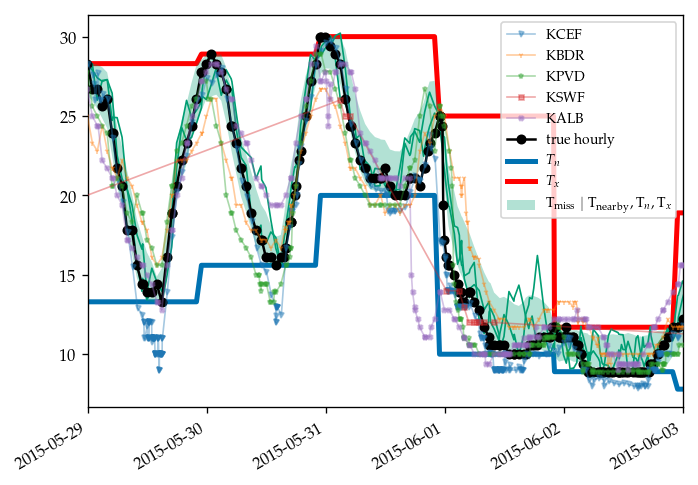

size(chainsarray) = (1000, 587, 4)


In [35]:
chainsarray = Chains(simlocal[2], simlocal[3])
@show size(chainsarray)
temp_impute_local = get_temperatures_reparam(chainsarray);

Batch.plot_imputations(ts_window, temp_impute_local, local_time; plot_mean=false, impt_indices=[250,500])
plt.gcf()[:autofmt_xdate]()
plt.xlim(Date(2015,5,29), Date(2015,6,3))
# plt.ylim(0,7)
_xlim = plt.xlim()
_ylim = plt.ylim()
Batch.plot_neighbours(hourly_train, 
                      isd_nearest_and_test,
                      local_time,
                      (DateTime(2015,5,2),DateTime(2015,7,14));
                      subtractmean=false,
#                       color="black",
                      linewidth=1,
                      markersize=3,
                      alpha=0.4,
                      zorder=10)
fw = Batch.FittingWindow(DateTime(2015,5,2),DateTime(2015,7,14))
Batch.plot_truth(hourly_test, fw, hr_measure, local_time)
Batch.plot_TnTx(hourly_cat, 1, hr_measure, local_time)
plt.xlim(_xlim)
plt.ylim(_ylim)
plt.legend(loc="auto", fontsize="small")
;

This is a bit inconclusive. We see a widening of the credible interval of course. What's encouraging is that on June 1st it only widens towards the truth in the first half of the day.
At the end of the day, it can only widen up (imputations can't go down because of $T_n$), so we incur additional error there.

## Comparison

In [38]:
june1 = hourly_test[hourly_test[:ts_day] .== Date(2015,6,1), :]
true_mean_june1 = mean(june1[:temp])

13.378260869565224

In [39]:
impute_june1 = temp_impute[:,[t ∈ june1[:ts] for t in ts_window],:]
mean(impute_june1) - true_mean_june1

1.772523093369557

In [41]:
impute_june1_local = temp_impute_local[
    :, # samples
    [t ∈ june1[:ts] for t in ts_window], # time
    :] # chain
mean(impute_june1_local) - true_mean_june1

1.8255648221739076

In [54]:
imputedmean       = collect(vec(mean(impute_june1; dims=2)))
imputedmean_local = collect(vec(mean(impute_june1_local; dims=2)))
;

In [56]:
sigma_impute = (mean(imputedmean)-true_mean_june1)/std(imputedmean)
sigma_local = (mean(imputedmean_local)-true_mean_june1)/std(imputedmean_local)
sigma_impute, sigma_local

(4.5954915978169115, 3.7278132994449766)

So we see some reduction in the sigmas, but less than I'd hoped, and mostly due to the widening credible interval (the imputed mean actually got worse).